In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

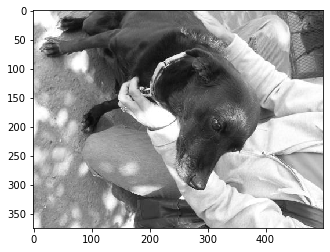

In [2]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

#Import data for training 

DATADIR = "../input/10k-pets/10K_pets/Pets"

CATEGORIES = ["Dog", "Cat"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

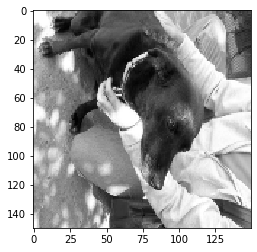

(375, 500)


In [3]:
#resize image for input to CNN

IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()
print(img_array.shape)

In [4]:
#create training data
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data()

#shuffle training data to avoid bias when training 

import random 
random.shuffle(training_data)


X_train = []
y_train = []

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

#standardise to a value between 0 - 1 

X_train = X_train/255.0

X_train.shape
y_train.shape

100%|██████████| 4905/4905 [00:11<00:00, 419.95it/s]


(9790,)

In [5]:
print(X_train.shape)
print(y_train.shape)

(9790, 150, 150, 1)
(9790,)


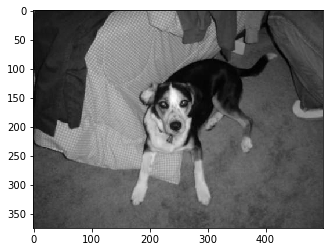

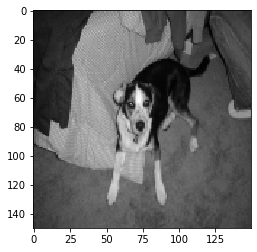

 44%|████▍     | 44/100 [00:00<00:00, 437.70it/s]

(375, 500)


100%|██████████| 100/100 [00:00<00:00, 458.85it/s]

200


In [6]:
#create testing data by following all the same steps as when creating training data, yet input images are different and un-seen to the model 

TESTDIR = "../input/testing-pets/Testing"

CATEGORIES = ["Dog", "Cat"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(TESTDIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!
    
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()
print(img_array.shape)

testing_data = []

def create_testing_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(TESTDIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_testing_data()


import random 
random.shuffle(testing_data)


X_test = []
y_test = []

for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

X_test = X_test/255.0

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

X_test.shape
y_test.shape

print(len(X_test))

In [7]:
from tensorflow.keras.optimizers import Optimizer, RMSprop
from tensorflow.keras import backend as K
if K.backend() == 'tensorflow':
    import tensorflow as tf
import math

#WAME implementation 
# line 1 + 2 of WAME initalising variables 

class WAME(RMSprop):
    def __init__(self, alpha = 0.9, scale_up = 1.2, scale_down = 0.1, zeta_min = 0.01, 
                 zeta_max = 100, lr = 0.001,
                 **kwargs):
        
        self.initial_t = kwargs.pop('t', 0.0)
        
        super(WAME, self).__init__(**kwargs)
        self.alpha = K.variable(alpha, name='alpha')
        self.scale_up = K.variable(scale_up, name='scale_up')
        self.scale_down = K.variable(scale_down, name='scale_down')
        self.zeta_min = K.variable(zeta_min, name='zeta_min')
        self.zeta_max = K.variable(zeta_max, name='zeta_max')
        self.lr = K.variable(lr, name='lr')
        self.t = K.variable(self.initial_t, name='t')
        
        
    def get_updates(self, params, constraints, loss):
        
        grads = self.get_gradients(loss, params)
        
        shapes = [K.get_variable_shape(p) for p in params]
        
        old_grads = [K.zeros(shape) for shape in shapes]
        
        self.updates = []
        
        new_zeta = [K.zeros(K.int_shape(p),
              dtype=K.dtype(p),
              name='new_zeta_' + str(i))
              for (i, p) in enumerate(params)]
        
        Z = [K.zeros(K.int_shape(p),
              dtype=K.dtype(p),
              name='Z_' + str(i))
              for (i, p) in enumerate(params)]
        
        theta = [K.zeros(K.int_shape(p),
              dtype=K.dtype(p),
              name='theta_' + str(i))
              for (i, p) in enumerate(params)]


        for param, grad, old_grad, new_zeta, Z, theta in zip(params, grads, old_grads, new_zeta, Z, theta):
            
            new_step = K.switch(
                K.greater(grad * old_grad, 0),
                
                K.minimum(new_zeta * self.scale_up, self.zeta_max),
                
                K.maximum(new_zeta * self.scale_down, self.zeta_min)
            )
            
            Z_updated = ((self.alpha * Z) + ((1. - self.alpha) * new_step))
            
            theta_updated = ((self.alpha * theta) + ((1. - self.alpha) * ((grad * self.t)**2)))
            
            new_t = (-self.lr * Z_updated * grad * (math.sqrt(1/theta_updated)))
            
            new_param = param + new_t 
            
            # Apply constraints
            if param in constraints:
                c = constraints[param]
                new_param = c(new_param)
                
                
            self.updates.append(K.update(param, new_param))
            self.updates.append(K.update(old_grad, grad))
            self.updates.append(K.update(new_zeta, new_step))
            self.updates.append(K.update(Z, Z_updated))
            self.updates.append(K.update(theta, theta_updated))
            
        return self.updates
    
    def get_config(self):
        config = {
            'alpha': float(K.get_value(self.alpha)),
            'scale_up': float(K.get_value(self.scale_up)),
            'scale_down': float(K.get_value(self.scale_down)),
            'zeta_min': float(K.get_value(self.zeta_min)),
            'zeta_max': float(K.get_value(self.zeta_max)),
            'lr': float(K.get_value(self.lr)),
            't': float(K.get_value(self.t)),
        }
        
        base_config = super(WAME, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    
    


In [8]:
opt = WAME(name="WAME")

Train on 8811 samples, validate on 979 samples
Epoch 1/20
8811/8811 [==============================] - 8s 896us/sample - loss: 0.6772 - accuracy: 0.5722 - val_loss: 0.6432 - val_accuracy: 0.6282
Epoch 2/20
8811/8811 [==============================] - 4s 415us/sample - loss: 0.6161 - accuracy: 0.6675 - val_loss: 0.6017 - val_accuracy: 0.6844
Epoch 3/20
8811/8811 [==============================] - 4s 431us/sample - loss: 0.5429 - accuracy: 0.7309 - val_loss: 0.5568 - val_accuracy: 0.7436
Epoch 4/20
8811/8811 [==============================] - 4s 425us/sample - loss: 0.4887 - accuracy: 0.7680 - val_loss: 0.5294 - val_accuracy: 0.7559
Epoch 5/20
8811/8811 [==============================] - 4s 413us/sample - loss: 0.4407 - accuracy: 0.7976 - val_loss: 0.5626 - val_accuracy: 0.7549
Epoch 6/20
8811/8811 [==============================] - 4s 416us/sample - loss: 0.4082 - accuracy: 0.8181 - val_loss: 0.5249 - val_accuracy: 0.7804
Epoch 7/20
8811/8811 [==============================] - 4s 427us/

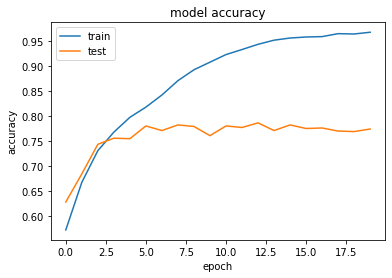

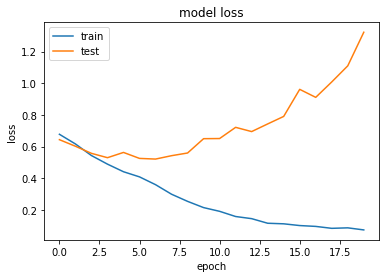

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#fit model 

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

#analyse accuracy and loss of model 

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [10]:
#get results from test-set 

scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)
print("Deep CNN Error: {:.2f}%".format(100 - scores[1] * 100))


[1.002581949234009, 0.83]
Deep CNN Error: 17.00%


Train on 8811 samples, validate on 979 samples
Epoch 1/20
8811/8811 [==============================] - 4s 480us/sample - loss: 0.6913 - accuracy: 0.5218 - val_loss: 0.6891 - val_accuracy: 0.5894
Epoch 2/20
8811/8811 [==============================] - 4s 417us/sample - loss: 0.6872 - accuracy: 0.5532 - val_loss: 0.6866 - val_accuracy: 0.5169
Epoch 3/20
8811/8811 [==============================] - 4s 414us/sample - loss: 0.6822 - accuracy: 0.5658 - val_loss: 0.6781 - val_accuracy: 0.5812
Epoch 4/20
8811/8811 [==============================] - 4s 419us/sample - loss: 0.6783 - accuracy: 0.5767 - val_loss: 0.6749 - val_accuracy: 0.6118
Epoch 5/20
8811/8811 [==============================] - 4s 412us/sample - loss: 0.6731 - accuracy: 0.5869 - val_loss: 0.6643 - val_accuracy: 0.6159
Epoch 6/20
8811/8811 [==============================] - 4s 412us/sample - loss: 0.6701 - accuracy: 0.5873 - val_loss: 0.6794 - val_accuracy: 0.5536
Epoch 7/20
8811/8811 [==============================] - 4s 423us/

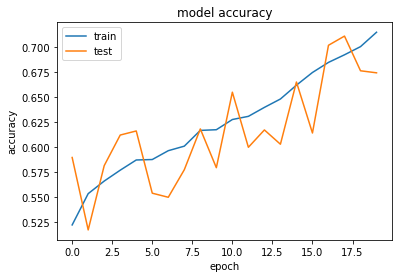

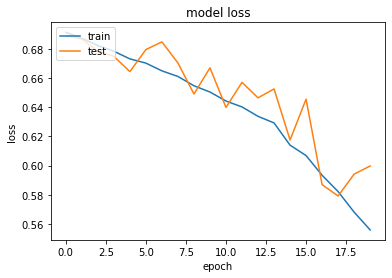

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)
print("Deep CNN Error: {:.2f}%".format(100 - scores[1] * 100))

[0.5672474336624146, 0.715]
Deep CNN Error: 28.50%


Train on 8811 samples, validate on 979 samples
Epoch 1/20
8811/8811 [==============================] - 5s 528us/sample - loss: 0.6760 - accuracy: 0.5904 - val_loss: 0.5916 - val_accuracy: 0.7130
Epoch 2/20
8811/8811 [==============================] - 4s 439us/sample - loss: 0.5712 - accuracy: 0.7087 - val_loss: 0.5611 - val_accuracy: 0.7283
Epoch 3/20
8811/8811 [==============================] - 4s 466us/sample - loss: 0.4923 - accuracy: 0.7674 - val_loss: 0.5115 - val_accuracy: 0.7661
Epoch 4/20
8811/8811 [==============================] - 4s 462us/sample - loss: 0.4478 - accuracy: 0.7892 - val_loss: 0.4835 - val_accuracy: 0.7875
Epoch 5/20
8811/8811 [==============================] - 4s 439us/sample - loss: 0.4111 - accuracy: 0.8182 - val_loss: 0.5366 - val_accuracy: 0.7579
Epoch 6/20
8811/8811 [==============================] - 4s 444us/sample - loss: 0.3779 - accuracy: 0.8306 - val_loss: 0.5123 - val_accuracy: 0.7978
Epoch 7/20
8811/8811 [==============================] - 4s 426us/

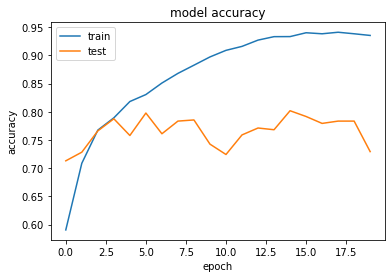

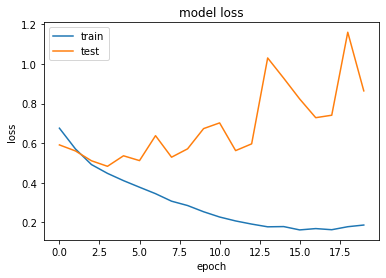

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)
print("Deep CNN Error: {:.2f}%".format(100 - scores[1] * 100))

[0.6035672616958618, 0.785]
Deep CNN Error: 21.50%


Train on 8811 samples, validate on 979 samples
Epoch 1/20
8811/8811 [==============================] - 5s 525us/sample - loss: 0.6776 - accuracy: 0.5842 - val_loss: 0.6584 - val_accuracy: 0.6190
Epoch 2/20
8811/8811 [==============================] - 4s 430us/sample - loss: 0.5788 - accuracy: 0.6991 - val_loss: 0.6100 - val_accuracy: 0.6905
Epoch 3/20
8811/8811 [==============================] - 4s 442us/sample - loss: 0.5141 - accuracy: 0.7491 - val_loss: 0.5736 - val_accuracy: 0.7191
Epoch 4/20
8811/8811 [==============================] - 4s 431us/sample - loss: 0.4542 - accuracy: 0.7862 - val_loss: 0.6214 - val_accuracy: 0.6946
Epoch 5/20
8811/8811 [==============================] - 4s 433us/sample - loss: 0.4185 - accuracy: 0.8086 - val_loss: 0.4708 - val_accuracy: 0.7998
Epoch 6/20
8811/8811 [==============================] - 4s 437us/sample - loss: 0.3903 - accuracy: 0.8245 - val_loss: 0.4978 - val_accuracy: 0.7835
Epoch 7/20
8811/8811 [==============================] - 4s 435us/

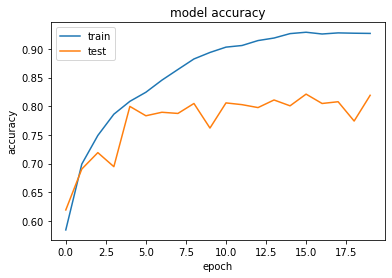

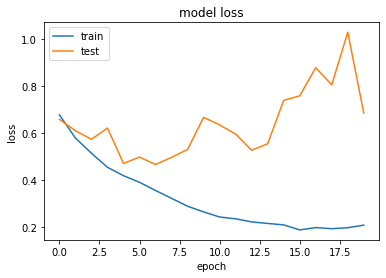

In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [16]:
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)
print("Deep CNN Error: {:.2f}%".format(100 - scores[1] * 100))

[0.48817609548568724, 0.835]
Deep CNN Error: 16.50%


In [17]:
from tensorflow.keras.optimizers import Optimizer, RMSprop
from tensorflow.keras import backend as K
if K.backend() == 'tensorflow':
    import tensorflow as tf
import math

#WAME implementation 
# line 1 + 2 of WAME initalising variables 

class WAME(RMSprop):
    def __init__(self, alpha = 0.9, scale_up = 1.2, scale_down = 0.1, zeta_min = 0.01, 
                 zeta_max = 100, lr = 0.01,
                 **kwargs):
        
        self.initial_t = kwargs.pop('t', 0.0)
        
        super(WAME, self).__init__(**kwargs)
        self.alpha = K.variable(alpha, name='alpha')
        self.scale_up = K.variable(scale_up, name='scale_up')
        self.scale_down = K.variable(scale_down, name='scale_down')
        self.zeta_min = K.variable(zeta_min, name='zeta_min')
        self.zeta_max = K.variable(zeta_max, name='zeta_max')
        self.lr = K.variable(lr, name='lr')
        self.t = K.variable(self.initial_t, name='t')
        
        
    def get_updates(self, params, constraints, loss):
        
        grads = self.get_gradients(loss, params)
        
        shapes = [K.get_variable_shape(p) for p in params]
        
        old_grads = [K.zeros(shape) for shape in shapes]
        
        self.updates = []
        
        new_zeta = [K.zeros(K.int_shape(p),
              dtype=K.dtype(p),
              name='new_zeta_' + str(i))
              for (i, p) in enumerate(params)]
        
        Z = [K.zeros(K.int_shape(p),
              dtype=K.dtype(p),
              name='Z_' + str(i))
              for (i, p) in enumerate(params)]
        
        theta = [K.zeros(K.int_shape(p),
              dtype=K.dtype(p),
              name='theta_' + str(i))
              for (i, p) in enumerate(params)]


        for param, grad, old_grad, new_zeta, Z, theta in zip(params, grads, old_grads, new_zeta, Z, theta):
            
            new_step = K.switch(
                K.greater(grad * old_grad, 0),
                
                K.minimum(new_zeta * self.scale_up, self.zeta_max),
                
                K.maximum(new_zeta * self.scale_down, self.zeta_min)
            )
            
            Z_updated = ((self.alpha * Z) + ((1. - self.alpha) * new_step))
            
            theta_updated = ((self.alpha * theta) + ((1. - self.alpha) * ((grad * self.t)**2)))
            
            new_t = (-self.lr * Z_updated * grad * (math.sqrt(1/theta_updated)))
            
            new_param = param + new_t 
            
            # Apply constraints
            if param in constraints:
                c = constraints[param]
                new_param = c(new_param)
                
                
            self.updates.append(K.update(param, new_param))
            self.updates.append(K.update(old_grad, grad))
            self.updates.append(K.update(new_zeta, new_step))
            self.updates.append(K.update(Z, Z_updated))
            self.updates.append(K.update(theta, theta_updated))
            
        return self.updates
    
    def get_config(self):
        config = {
            'alpha': float(K.get_value(self.alpha)),
            'scale_up': float(K.get_value(self.scale_up)),
            'scale_down': float(K.get_value(self.scale_down)),
            'zeta_min': float(K.get_value(self.zeta_min)),
            'zeta_max': float(K.get_value(self.zeta_max)),
            'lr': float(K.get_value(self.lr)),
            't': float(K.get_value(self.t)),
        }
        
        base_config = super(WAME, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    
    

Train on 8811 samples, validate on 979 samples
Epoch 1/20
8811/8811 [==============================] - 4s 511us/sample - loss: 0.6787 - accuracy: 0.5962 - val_loss: 0.5855 - val_accuracy: 0.7089
Epoch 2/20
8811/8811 [==============================] - 4s 434us/sample - loss: 0.5603 - accuracy: 0.7143 - val_loss: 0.5637 - val_accuracy: 0.7222
Epoch 3/20
8811/8811 [==============================] - 4s 424us/sample - loss: 0.4945 - accuracy: 0.7651 - val_loss: 0.6164 - val_accuracy: 0.6925
Epoch 4/20
8811/8811 [==============================] - 4s 440us/sample - loss: 0.4473 - accuracy: 0.7982 - val_loss: 0.6430 - val_accuracy: 0.6874
Epoch 5/20
8811/8811 [==============================] - 4s 430us/sample - loss: 0.4149 - accuracy: 0.8127 - val_loss: 0.4556 - val_accuracy: 0.8080
Epoch 6/20
8811/8811 [==============================] - 4s 419us/sample - loss: 0.3793 - accuracy: 0.8378 - val_loss: 0.5947 - val_accuracy: 0.7743
Epoch 7/20
8811/8811 [==============================] - 4s 423us/

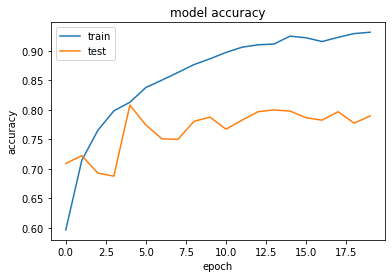

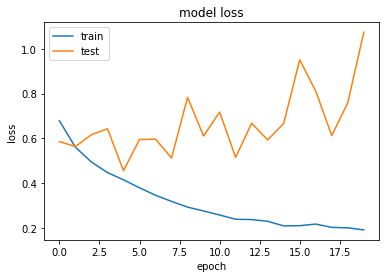

In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)
print("Deep CNN Error: {:.2f}%".format(100 - scores[1] * 100))

[0.9065076541900635, 0.765]
Deep CNN Error: 23.50%
